## Importing the libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# Saving the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "AirBnB-London-2020"
IMAGES_PATH = "Images"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Reading in the data file

In [ ]:
df_listings = pd.read_csv('Data/listings.csv', dtype={'listing_url': 'object',
                                                      'price': 'object',
                                                      'weekly_price': 'object',
                                                      'monthly_price': 'object',
                                                      'security_deposit': 'object',
                                                      'cleaning_fee': 'object',
                                                      'extra_people': 'object',
                                                      'license': 'object', 
                                                      'jurisdiction_names': 'object',})

In [ ]:
df_listings.shape

In [ ]:
pd.set_option('display.max_columns', None)

# show listings data sample
df_listings.head(3)

In [ ]:
class format_data:
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def data_float(self):
        self = self.str.replace('$', '', regex=True).replace(',', '', regex=True).astype(float)
        
        return self
    
    def data_percentage(self):
        self = (self.str.replace('%', '', regex=True).astype('float')) / 100
        
        return self
    
    def dict_to_list(self):
        self = self.str.replace('{', '', regex=True).replace('}', '', regex=True).replace('\"', '', regex=True)
        self = self.str.split(',')
              
        return self

In [ ]:
float_list = ['price','security_deposit','cleaning_fee','extra_people']
for x in float_list:
    df_listings[x] = format_data.data_float(df_listings[x])

In [ ]:
float_list = ['host_response_rate','host_acceptance_rate']
for x in float_list:
    df_listings[x] = format_data.data_percentage(df_listings[x])

In [ ]:
df_listings['amenities'] = format_data.dict_to_list(df_listings['amenities'])

## Data Exploration

In [ ]:
df_listings.describe()

In [ ]:
df_listings.hist(bins=50, figsize=(30,30))
plt.show()

In [ ]:
set(df_listings.columns[df_listings.isnull().mean()>0.75])

### Removing Price Outliers

In [ ]:
def find_outliers(df_listings):
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_listings["price"], 25)
    
    #Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_listings["price"],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    #print("Data points considered outliers for the feature '{}':".format("price"))
    filtered_data = df_listings[~((df_listings["price"] >= Q1 - step) & 
                                  (df_listings["price"] <= Q3 + step))].sort_values(by=["price"])
                                  
    #filtered_data["price"].hist()
    #outliers = filtered_data[filtered_data["price"] >= 1000.00]
    
    return filtered_data
                                  
                                  
outliers = find_outliers(df_listings).index
                                  
df_listings = df_listings.drop(df_listings.index[outliers]).reset_index(drop = True)

In [ ]:
df_listings["price"].hist()

In [ ]:
neighbourhood_vals = df_listings['property_type'].value_counts()

# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

((neighbourhood_vals[0:5]/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("Top 5 type of properties, that are most advertised");

In [ ]:
room_vals = df_listings['room_type'].value_counts()

# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

((room_vals/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("The type of rooms, are most advertised");

In [ ]:
df_listings.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(15,10),
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c="price", cmap=plt.get_cmap('jet'), 
                 colorbar=True,
                 sharex=False)
plt.show()

In [ ]:
import geopandas as gpd
# pip Install descartes

fig, ax = plt.subplots(1, 1, figsize=(15,10))

basemap = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
basemap = basemap.to_crs(epsg=4326)


basemap = basemap.plot(alpha=0.5, edgecolor='k',color='White',figsize=(15,10),ax=ax)
basemap.set_facecolor('black')


x, y = df_listings['longitude'].values, df_listings['latitude'].values
basemap.scatter(x,y, alpha=0.5,
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c=df_listings["price"], cmap=plt.get_cmap('jet'))


sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'))
prices = df_listings["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = fig.colorbar(sm, ticks=tick_values/prices.max(), alpha=0.5)
cbar.ax.set_yticklabels(["£%d"% v for v in tick_values], fontsize=10)
cbar.set_label('Price Value', fontsize=10)

# Removing ticks
plt.xticks([]),
plt.yticks([])

plt.legend(fontsize=10)
save_fig("availability_365_prices_scatterplot")
plt.show()

### What are Airbnb current challanges?

### What is the average price of the listings, for the different location within London?

In [ ]:
price_df = df_listings[df_listings['price'].isnull() == False]

In [ ]:
price_df['neighbourhood_cleansed'].value_counts()[:5]

In [ ]:
nb_price_avg = price_df.groupby('neighbourhood_cleansed', as_index=False).mean()
nb_price_avg = pd.DataFrame(nb_price_avg).sort_values(by='price', ascending=False)

In [ ]:
nb_price_avg = nb_price_avg.rename(columns={'neighbourhood_cleansed':'Neighbourhood','price': 'Avg Price'})

In [ ]:
def chart_plot(data, x_label, y_label):
    
    plt.figure(figsize=(10,5))

    sns.set(style="whitegrid")
    chart = sns.barplot(x=x_label, y=y_label, data=data)

    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=60, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='medium', 
        rotation_mode='anchor'
    )

In [ ]:
chart_plot(nb_price_avg,"Neighbourhood", "Avg Price")
save_fig("Neighbourhood_av_price_histogram_plots")

### What types of verifications are hosts using? How long did it take them to respond?

In [ ]:
verifications_df = df_listings[df_listings['host_verifications'].isnull() == False]

In [ ]:
verifications_df = verifications_df[verifications_df['host_verifications'] != '[]']

In [ ]:
def verifications_types(column):
    verifications_dict = {}
    temp = []

    for i in column:
        temp.append(eval(i))
    
    for i in temp:
        try:
            for j in i:
                if j not in verifications_dict:
                    verifications_dict[j] = 1
                else:
                    verifications_dict[j] += 1
        except:
            continue
            
    return verifications_dict
        
verifications_types = verifications_types(verifications_df['host_verifications'])

In [ ]:
for k,v in verifications_types.items():
    verifications_types[k] = round(v / verifications_df.shape[0] * 100, 3)

In [ ]:
verifications_types = pd.DataFrame.from_dict(verifications_types,orient='index',columns=['A']).reset_index()
verifications_types = verifications_types.rename(columns={'index':'Verification Type','A': '% of listings'})
top10_verifications_types = verifications_types.sort_values(by='% of listings', ascending=False)[:10]

In [ ]:
chart_plot(top10_verifications_types,"Verification Type", "% of listings")
save_fig("Verification_type_price_histogram_plots")

### What amenities are most used and does the count of amenities affect the review? 

In [ ]:
df_left = df_listings[['id','amenities']]

In [ ]:
df_right = df_listings[['id','review_scores_value']]

In [ ]:
df_left.head()

In [ ]:
df_left = df_left.amenities.apply(pd.Series).merge(df_left, right_index = True, 
                                         left_index = True) \
                                  .drop(["amenities"], axis = 1) \
                                  .melt(id_vars = ['id'], value_name = "amenities") \
                                  .drop("variable", axis = 1) \
                                  .dropna()

In [ ]:
result = pd.merge(df_left, df_right, on='id')

In [ ]:
result = result.groupby('amenities').mean()['review_scores_value'] \
                                    .reset_index() \
                                    .sort_values(by='review_scores_value',ascending=False)

In [ ]:
result.head(20)

### What features assist in the pricing of a listing? 
- Could the price be predicted?
- importance of the features, rank features

### Preparing data

In [ ]:
# Creating the 'amenities - count' column
df_listings['amenities - count'] = [len(i) for i in df_listings['amenities']]

In [ ]:
def fill_na_data(df_listings):
    
    # filling float or int columns with the mean value of the column
    num_vars = df_listings.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df_listings[col].fillna((df_listings[col].mean()), inplace=True)
        
        
    # filling the categorial columns with text
    df_listings['host_response_time'].fillna('No Response', inplace=True)
    df_listings['host_is_superhost'].fillna('f', inplace=True)
    df_listings['host_has_profile_pic'].fillna('f', inplace=True)
    df_listings['bed_type'].fillna('Unknown', inplace=True)
    
    return df_listings

df_listings = fill_na_data(df_listings)

In [ ]:
def drop_columns(df_listings):
    
    # Dropping Columns that aren't needed
    regex_list = ['url','id','scraped','first_review','last_review']
    for i in regex_list:
        df_listings = df_listings[df_listings.columns.drop(list(df_listings.filter(regex=i)))]
        
    df_listings = df_listings.drop(columns=['name','summary','space','description','neighborhood_overview','notes',
                                            'transit','access','interaction','house_rules','host_name','host_about',
                                            'latitude','longitude','host_since','host_neighbourhood','street',
                                            'neighbourhood','market','host_location','city','state','zipcode',
                                            'smart_location','country_code','country','amenities', 'host_verifications'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df_listings.columns[df_listings.isnull().mean()>0.70])
    df_listings = df_listings.drop(list(col_nulls), axis=1)
    
    return df_listings

df_listings = drop_columns(df_listings)

In [ ]:
# Removing rows that do not have a price
df = df_listings.dropna(subset=["price"])

In [ ]:
# Dummy the categorical variables
cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var],
                                                         prefix=var, prefix_sep='_', drop_first=True)], axis=1)

### Building the Model

In [ ]:
X = df.drop('price', axis = 1)
y = df['price']

In [ ]:
X.shape

In [ ]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_regression
#fs = SelectKBest(score_func=f_regression, k=200)

#X_selected = fs.fit_transform(X, y)
#print(X_selected)

In [ ]:
#X_new.shape

In [ ]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### Fittng the training data with various models

In [ ]:
def model_fit(model,X,y):
    
    model.fit(X,y)
    
    return model

In [ ]:
def model_rmse(model, X_test, y_test):
    predictions = model.predict(X_test) 
    mse = mean_squared_error(y_test,predictions) 
    rmse = np.sqrt(mse) 
    
    return rmse

In [ ]:
# Linear Regression
lin_reg = LinearRegression()
model_fit(lin_reg, X_train, y_train)

In [ ]:
# Linear Regression - RMSE
model_rmse(lin_reg, X_test, y_test)

In [ ]:
# Decision Tree Regression
tree_reg = DecisionTreeRegressor()
model_fit(tree_reg, X_train, y_train)

In [ ]:
# Decision Tree Regression - RMSE
model_rmse(tree_reg, X_test, y_test)

In [ ]:
# Random Forest Regression

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

In [ ]:
model_fit(forest_reg, X_train, y_train)

In [ ]:
# Random Forest Regression - RMSE
model_rmse(forest_reg, X_test, y_test)

### Finding the scores, mean and standard variations of the different models

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
def display_scores(model,X_train,y_train):
    
    scores = cross_val_score(model,X_train,y_train,scoring = "neg_mean_squared_error",cv = 10, n_jobs=-1)
    model_rmse_scores = np.sqrt(-scores) 
    
    print("Scores:",model_rmse_scores)
    print("Mean:",model_rmse_scores.mean())
    print ("Standard deviation:",model_rmse_scores.std())

In [ ]:
# Linear Regression
display_scores(lin_reg,X_train,y_train)

In [ ]:
# Decision Tree Regression
display_scores(tree_reg,X_train,y_train)

In [ ]:
# Random Forest Regression
display_scores(forest_reg,X_train,y_train)

### Explore Number of Features

In [4]:
import pickle

def open_file(file_name):
    
    open_file = open(file_name, "rb")
    my_results, my_names = pickle.load(open_file)
    open_file.close()
    
    for name, scores in zip(my_names, my_results):
        # summarize the performance along the way
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
       
    return my_results, my_names

my_results, my_names = open_file("eval_feat_models.pickle")

>auto 32.835 (2.261)
>None 32.814 (2.274)
>sqrt 32.702 (2.328)
>log2 33.317 (2.294)
>0.7 32.551 (2.291)
>0.2 32.311 (2.311)


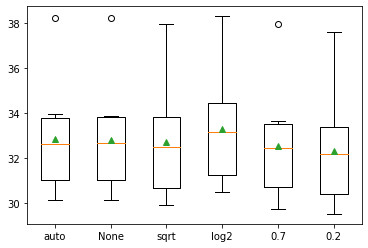

In [5]:
# plot model performance for comparison
plt.boxplot(my_results, labels=my_names, showmeans=True)
plt.show()

### Explore Number of Trees

>100 32.813 (2.290)
>200 32.733 (2.272)
>300 32.692 (2.270)
>400 32.671 (2.257)
>500 32.678 (2.260)


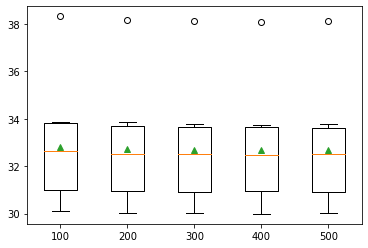

In [6]:
tree_results, tree_names = open_file("eval_tree_models.pickle")

# plot model performance for comparison
plt.boxplot(tree_results, labels=tree_names, showmeans=True)
plt.show()

### Explore Tree Depth

>1 44.264 (2.181)
>2 40.945 (2.119)
>3 39.171 (2.181)
>4 37.967 (2.282)
>5 37.039 (2.384)
>10 34.066 (2.234)
>20 32.847 (2.277)
>50 32.793 (2.288)
>100 32.800 (2.281)
>None 32.838 (2.267)


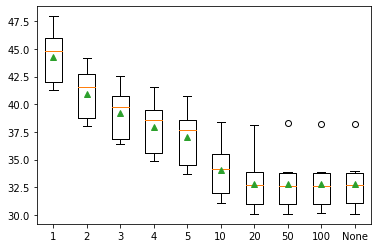

In [7]:
depth_results, depth_names = open_file("eval_depth_models.pickle")

# plot model performance for comparison
plt.boxplot(depth_results, labels=depth_names, showmeans=True)
plt.show()

#### GridSearchCV - Finding the best parameters

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


def grid_search(X_train, y_train):
    """ Performs grid search over parameters for a 
        radom fores regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 42)

    # Create a RandomForestRegressor object
    regressor = RandomForestRegressor(oob_score=True, n_jobs=-1, random_state=42)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    param_grid = [ 
        { 'n_estimators':[100, 200], 'max_features':[(X.shape[0])/3]}, 
        { 'bootstrap':[False], 'n_estimators':[100, 200], 'max_features':['auto', None, 'sqrt', 'log2', 0.7, 0.2]},
    ]

    # Create the grid search object #scoring=scoring_fnc
    grid_search = GridSearchCV(regressor, param_grid, cv=cv_sets, 
                               scoring='neg_mean_squared_error',
                               return_train_score=True)

    # Fit the grid search object to the data to compute the optimal model
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    cv_results = grid_search.cv_results_
    feature_importances = grid_search.best_estimator_.feature_importances_
    final_model = grid_search.best_estimator_
    
    # Return the optimal model after fitting the data
    return best_params, cv_results, feature_importances, final_model

In [ ]:
# Fit the training data to the model using grid search
best_params, cv_results, feature_importances, final_model = grid_search(X_train, y_train)

# Produce the best params
print(best_params)

In [ ]:
# Finding the best evaluation scores
for mean_score, params in zip (cv_results["mean_test_score"], cv_results["params"]):
    print(round(np.sqrt(-mean_score),2),params)

In [ ]:
# Finding the feature importance
# feature_importances

In [ ]:
# Display the feature importance scores
# extra_attribs = ["rooms_per_hhold","pop_per_hhold","bedrooms_per_room"]
# cat_encoder = full_pipeline.named_transformers_ ["cat"]
# cat_one_hot_attribs = list(cat_encoder.categories_[0])
# attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances,X_train.columns),reverse = True) 

In [ ]:
# Evaluate the system on the test set
model_rmse(final_model, X_test, y_test)